## Лабораторна робота 7 з ІСППР
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.
### Варіант 8 арифметичної нормалізації, HCR, мультиплікативний

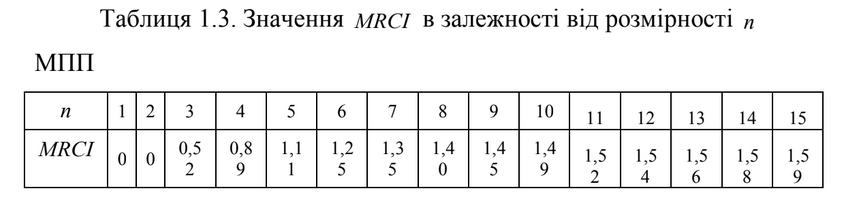

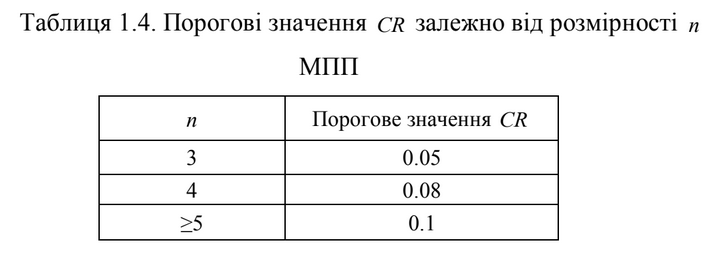

# Imports

In [10]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from copy import deepcopy
import numpy as np

# Model training using grid search and metrics calculation

In [18]:
# Load dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

RAND_CONST = 10

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RAND_CONST)

# Define models
models = {
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=RAND_CONST),
    'svm': SVC(random_state=RAND_CONST),
    'random_forest': RandomForestClassifier(random_state=RAND_CONST),
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(random_state=RAND_CONST)
}

# Define hyperparameters for each model
params = {
    'logistic_regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'svm': {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'classifier__gamma': ['scale', 'auto']},
    'random_forest': {'classifier__n_estimators': [50, 100, 200, 350], 'classifier__max_depth': [None, 5, 10, 15, 20], 'classifier__min_samples_split': [2, 5, 10]},
    'knn': {'classifier__n_neighbors': [3, 5, 7, 9, 11], 'classifier__weights': ['uniform', 'distance'], 'classifier__p': [1, 2]},
    'decision_tree': {'classifier__max_depth': [None, 5, 10, 15, 20], 'classifier__min_samples_split': [2, 5, 10]}
}

# Perform GridSearchCV and evaluate models
metrics = {'f1': f1_score, 'roc_auc': roc_auc_score}
results = {metric: {} for metric in metrics}

for model in tqdm(models, total=len(models)):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=15)),
        ('classifier', models[model])
    ])
    grid = GridSearchCV(pipe, params[model], cv=5)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    for metric in metrics:
        results[metric][model] = metrics[metric](y_test, y_pred)  # Evaluate on the testing set

# Normalize metric values to get weight vectors
results_scaled = deepcopy(results)
for metric in results:
    values = np.array(list(results[metric].values()))
    values_scaled = values / np.sum(values)
    results_scaled[metric] = {model: weight for model, weight in zip(models, values_scaled)}

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
results

{'f1': {'logistic_regression': 0.965034965034965,
  'svm': 0.9659863945578231,
  'random_forest': 0.951048951048951,
  'knn': 0.9444444444444444,
  'decision_tree': 0.9115646258503401},
 'roc_auc': {'logistic_regression': 0.9553571428571429,
  'svm': 0.945436507936508,
  'random_forest': 0.9365079365079365,
  'knn': 0.9246031746031746,
  'decision_tree': 0.8700396825396826}}

## Local weights

In [20]:
results_scaled

{'f1': {'logistic_regression': 0.2036764029150177,
  'svm': 0.20387720780796362,
  'random_forest': 0.20072457098871313,
  'knn': 0.19933065035684705,
  'decision_tree': 0.19239116793145863},
 'roc_auc': {'logistic_regression': 0.20625401584921824,
  'svm': 0.20411222959948597,
  'random_forest': 0.20218462197472692,
  'knn': 0.19961447847504818,
  'decision_tree': 0.18783465410152067}}

In [53]:
def HM(weights):
    return len(weights) / np.sum(weights)
def HCI(weights):
    return (HM(weights) - len(weights)) * (len(weights) + 1) / (len(weights) * (len(weights) - 1))
def HCR(weights):
    return HCI(weights) / 1.11
def test_coherence(comparison_matrix):
    column_sums = np.sum(comparison_matrix, axis=0)
    weights = 1 / column_sums
    normalized_weights = weights / np.sum(weights) # Normalize the weights so they sum to 1
    indicator = HCR(weights)
    print("HCRN is coherent") if indicator <= 0.1 else print("HCRN isn't coherent")
    return normalized_weights, indicator

In [59]:
# Define a matrix of comparisons for the "ability to tweak model to your needs" of each model
comparison_matrix = np.array([
    [1  , 1/2, 1/4, 2  , 1/3],
    [2  , 1  , 1/3, 3  , 4  ],
    [4  , 3  , 1  , 5  , 3  ],
    [1/2, 1/3, 1/5, 1  , 1/4],
    [3  , 1/4, 1/3, 4  , 1  ]
])
weights_for_subjective_criterion, HCR_value = test_coherence(comparison_matrix)

HCRN is coherent


In [60]:
weights_for_subjective_criterion

array([0.10050752, 0.20760569, 0.49858059, 0.07035526, 0.12295094])

In [61]:
HCR_value

0.07476880943311598

## Global weights

In [70]:
criterion_weights = np.array([0.45, 0.35, 0.2]) # weights for the three criteria
def find_global_weights(results_scaled, weights_for_subjective_criterion, criterion_weights):
    local_weights_matrix = np.zeros((len(criterion_weights), len(weights_for_subjective_criterion)))
    for ind, metric in enumerate(results_scaled): # first two rows correspond to numerical metrics
        metric_values = np.array(list(results_scaled[metric].values()))
        local_weights_matrix[ind, :] = metric_values
    local_weights_matrix[-1, :] = weights_for_subjective_criterion # third row corresponds to the subjective criterion
    global_weight = np.prod(np.power(local_weights_matrix.T, criterion_weights), axis=1)
    return local_weights_matrix.T, global_weight

In [69]:
local_weights_matrix_T, global_weights = find_global_weights(results_scaled, weights_for_subjective_criterion)
for ind, model in enumerate(models):
    print(f"{model} global weight: {global_weights[ind]}")

logistic_regression global weight: 0.17762491169157274
svm global weight: 0.20470003366483328
random_forest global weight: 0.24139549345627243
knn global weight: 0.16193281557599146
decision_tree global weight: 0.17444205045820554


In [76]:
num_models = len(models)
for i in range(num_models):
    for j in range(i+1, num_models):
        if np.prod(np.power(local_weights_matrix_T[i, :] / local_weights_matrix_T[j, :], criterion_weights)):
            print(f"Model {list(models.keys())[i]} is preferred to model {list(models.keys())[j]}")
        else:
            print(f"Model {list(models.keys())[j]} is preferred to model {list(models.keys())[i]}")

Model logistic_regression is preferred to model svm
Model logistic_regression is preferred to model random_forest
Model logistic_regression is preferred to model knn
Model logistic_regression is preferred to model decision_tree
Model svm is preferred to model random_forest
Model svm is preferred to model knn
Model svm is preferred to model decision_tree
Model random_forest is preferred to model knn
Model random_forest is preferred to model decision_tree
Model knn is preferred to model decision_tree
